# UTH-BERTを利用してtoken classificationためのデータセット作成
UTH-BERTのtokenizationを利用してtoken作成、び及token classification taskためのlabel作成
>
uth-bert: https://ai-health.m.u-tokyo.ac.jp/home/research/uth-bert

In [1]:
import pandas as pd
import ast
import pickle
import copy
import unicodedata
import warnings
warnings.filterwarnings('ignore')

## Input data

In [5]:
with open('input_data/df_row_new.pkl', 'rb') as file:
    df_row=pickle.load(file)

In [7]:
"""
ROW_DATA = 'input_data/row_text_dataset.csv'
df_row = pd.read_csv(ROW_DATA)
for col in ['AE', 'PT', 'LLT', 'pick_word']:
    df_row[col] = df_row[col].apply(lambda x: ast.literal_eval(x))
"""
df_row['pick_word_num']=df_row['pick_words_new'].apply(lambda x:len(x) if x!=['記載なし'] else 0)

In [8]:
df_row

,level_0,file_name,management_number,row,AE,LLT,PT,pick_words_new,pick_word_num
0,7,./input\タグリッソ_20211001-1231.xlsx,202167639,10回目、DAY245、爪囲炎改善したが再増悪。,[爪囲炎再増悪],['爪囲炎'],['爪囲炎'],[爪囲炎],1
1,21,./input\イミフィンジ_20211001-1231.xlsx,202166641,18時頃突然の前胸部痛と冷汗あり。18:15頃に意識消失、CPR(心肺蘇生法)開始。酸素投与...,[心筋梗塞、心室細動],['心室細動'],['心室細動'],[心室細動],1
2,28,./input\リムパーザ_20220201-0331.xlsx,210003833,1コース目D21、GRADE2好中球減少発現。,[GRADE2好中球減少],['好中球数減少'],['好中球数減少'],[GRADE2好中球減少],1
3,33,./input\イミフィンジ_20211001-1231.xlsx,202171730,1コース目はシスプラチン投与の際のハイドレーションに伴い、一時的に体重増加(+3~4KG)、...,"[体重増加, 下肢浮腫, 腫瘍増大, 足がむくむ]","['体重増加', '下肢浮腫']","['体重増加', '末梢性浮腫']","[体重増加, 下肢浮腫]",2
4,34,./input\イミフィンジ_20211001-1231.xlsx,210009515,1コース目カルボプラチン(AUC5)、エトポシド(100MG/M2)にてG4の好中球減少、F...,"[G4の好中球減少, FN]","['好中球数減少', '発熱性好中球減少症']","['好中球数減少', '発熱性好中球減少症']","[G4の好中球減少, 発熱性好中球減少症]",2
...,...,...,...,...,...,...,...,...,...
7537,7211,./input\リンパーザ_20211001-1231.xlsx,202040106,乳癌再発。多発骨転移、多発肝転移と診断。,[多発肝転移],['肝転移'],['肝転移'],"[乳癌, 多発骨転移, 多発肝転移]",3
7538,7515,./input\イミフィンジ_20211001-1231.xlsx,210002674,転倒、頭部を打撲、右眼窩外側壁骨折、顔面挫創、糖尿、アラニンアミノトランスフェラーゼ増加、高...,"[転倒, 頭部を打撲, 右眼窩外側壁骨折, 顔面挫創, 糖尿, アラニンアミノトランスフェラ...","['転倒', '頭部挫傷', '眼窩骨折', '挫創', '糖尿', 'アラニンアミノトラン...","['転倒', '挫傷', '顔面骨骨折', '創傷', '糖尿', 'アラニンアミノトランス...","[転倒, 頭部を打撲, 右眼窩外側壁骨折, 挫創, 糖尿, アラニンアミノトランスフェラーゼ...",17
7539,7255,./input\リンパーザ_20211001-1231.xlsx,201936922,右側腹部痛と下腹部痛みあり。既往歴に憩室炎があるが、今は問題ない。,"[右側腹部痛, 下腹部痛]","['側腹部痛', '下腹部痛']","['側腹部痛', '下腹部痛']","[側腹部痛, 下腹部痛]",2
7541,7524,./input\タグリッソ_20220101-0430.xlsx,202168684,鑑別診断:潰瘍性大腸炎。,[薬剤性大腸炎],['大腸炎'],['大腸炎'],[大腸炎],1


In [9]:
df_row['pick_word_num'].value_counts()

1     5282
2     1360
3      368
4      127
5       48
6       27
7       19
9       12
8       11
13       6
11       6
12       5
10       5
15       3
14       2
16       1
17       1
Name: pick_word_num, dtype: int64

## UTH-BERT tokenization

In [10]:
from UTH_BERT.preprocess_text import preprocess as my_preprocess
from UTH_BERT.tokenization_mod import MecabTokenizer, FullTokenizerForMecab

In [11]:
def tokenizer(mecab_ipadic_neologd,mecab_J_medic,vocab_file):
    # special token for a Person's name (Do not change)
    name_token = "＠＠Ｎ"
    # MecabTokenizer
    sub_tokenizer = MecabTokenizer(mecab_ipadic_neologd=mecab_ipadic_neologd,
                               mecab_J_medic=mecab_J_medic,
                               name_token=name_token)
    # FullTokenizerForMecab
    tokenizer = FullTokenizerForMecab(sub_tokenizer=sub_tokenizer,
                                      vocab_file=vocab_file,
                                      do_lower_case=False)
    return tokenizer

In [12]:
# path to the mecab-ipadic-neologd
mecab_ipadic_neologd ='UTH_BERT/mecab-ipadic-neologd'
# path to the J-Medic (We used MANBYO_201907_Dic-utf8.dic)
mecab_J_medic = 'UTH_BERT/MANBYO_201907_Dic-utf8.dic'
# path to the uth-bert vocabulary
vocab_file = "UTH_BERT/UTH_BERT_BASE_512_MC_BPE_WWM_V25000_352K/vocab.txt"

tokenizer=tokenizer(mecab_ipadic_neologd,mecab_J_medic,vocab_file)

## Get tokens

In [13]:
def get_row_tokens(text,tokenizer,my_preprocess):
    pre_processed_text = my_preprocess(text)
    output_tokens = tokenizer.tokenize(pre_processed_text)
    return output_tokens

df_row['tokens'] = df_row['row'].apply(lambda x: get_row_tokens(x,tokenizer,my_preprocess))

In [14]:
df_row['token_length']=df_row['tokens'].apply(lambda x:len(x))

In [17]:
def get_pick_word_tokens(pick_word,tokenizer,my_preprocess):
    pick_word_=[]
    for p in pick_word:
        pick_word_.append(tokenizer.tokenize(my_preprocess(p)))
    return pick_word_

df_row['pick_word_tokens'] = df_row['pick_words_new'].apply(lambda x: get_pick_word_tokens(x,tokenizer,my_preprocess)if x!=['記載なし'] else x)

In [20]:
df_row[['row','tokens','token_length','pick_words_new','pick_word_tokens']]

,row,tokens,token_length,pick_words_new,pick_word_tokens
0,10回目、DAY245、爪囲炎改善したが再増悪。,"[１０回, 目, 、, ＤＡ, Ｙ, ２, ４, ５, 、, 爪, ##囲, ##炎, 改善...",18,[爪囲炎],"[[爪, ##囲, ##炎]]"
1,18時頃突然の前胸部痛と冷汗あり。18:15頃に意識消失、CPR(心肺蘇生法)開始。酸素投与...,"[１８時, 頃, 突然, の, 前胸部痛, と, 冷汗, あり, 。, １, ８, ：, １...",117,[心室細動],"[[心室, ##細, ##動]]"
2,1コース目D21、GRADE2好中球減少発現。,"[１, コース, 目, Ｄ, ２, １, 、, Ｇ, ＲＡ, ##Ｄ, Ｅ, ２, 好中球減...",15,[GRADE2好中球減少],"[[Ｇ, ＲＡ, ##Ｄ, Ｅ, ２, 好中球減少]]"
3,1コース目はシスプラチン投与の際のハイドレーションに伴い、一時的に体重増加(+3~4KG)、...,"[１, コース, 目, は, シスプラチン, 投与, の, 際, の, ハイ, ##ドレ, ...",32,"[体重増加, 下肢浮腫]","[[体重増加], [下肢浮腫]]"
4,1コース目カルボプラチン(AUC5)、エトポシド(100MG/M2)にてG4の好中球減少、F...,"[１, コース, 目, カルボプラチン, （, Ａ, ＵＣ, ５, ）, 、, エトポシド,...",33,"[G4の好中球減少, 発熱性好中球減少症]","[[Ｇ, ４, の, 好中球減少], [発熱性好中球, 減少症]]"
...,...,...,...,...,...
7537,乳癌再発。多発骨転移、多発肝転移と診断。,"[乳癌, ##再発, 。, 多発骨転移, 、, 多発肝転移, と, 診断, 。]",9,"[乳癌, 多発骨転移, 多発肝転移]","[[乳癌], [多発骨転移], [多発肝転移]]"
7538,転倒、頭部を打撲、右眼窩外側壁骨折、顔面挫創、糖尿、アラニンアミノトランスフェラーゼ増加、高...,"[転倒, 、, 頭部, を, 打撲, 、, 右, 眼窩, 外側, ##壁, 骨折, 、, 顔...",68,"[転倒, 頭部を打撲, 右眼窩外側壁骨折, 挫創, 糖尿, アラニンアミノトランスフェラーゼ...","[[転倒], [頭部, を, 打撲], [右, ##眼窩, ##外側, ##壁, ##骨折]..."
7539,右側腹部痛と下腹部痛みあり。既往歴に憩室炎があるが、今は問題ない。,"[右側腹部痛, と, 下腹部痛, ##み, あり, 。, 既往, 歴, に, 憩室, 炎, ...",20,"[側腹部痛, 下腹部痛]","[[側, ##腹部, ##痛], [下腹部痛]]"
7541,鑑別診断:潰瘍性大腸炎。,"[鑑別, 診断, ：, 潰瘍性大, 腸炎, 。]",6,[大腸炎],"[[大腸, ##炎]]"


## Create labels

label_list=[0,1,2]
<br>
    0==>  "0" indicates the token doesn’t correspond to any entity.
<br>
    1==>  "B" indicates the beginning of an entity.
<br>
    2==>  "I" indicates a token is contained inside the same entity

In [21]:
def index_func(token,pick_word_tokens):
    flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
    pick_word_tokens_flatten=flatten(pick_word_tokens)    

    label=[0 for i in range(len(token))]
    label_index=[i for i in range(len(token)) if token[i] in pick_word_tokens_flatten]
    label=[1 if i in label_index  else 0 for i in range(len(label))]
    index=[]
    subindex=[]
    for i in range(len(label)):
        if label[i]==1:
            subindex.append(i)
        if label[i]==0:
            index.append(subindex)
            subindex=[]
    index= list ( filter ( None , index))    

    # remove label_index中の'が' 'の' などのsingle index sublist   e.g.[['筋炎','の','可能性'].['の']]
    remove=['が','の'] 
    index_filter=[]
    for subindex in index:
        if len(subindex)==1 and token[subindex[0]] in remove:
            continue
        else:
            index_filter.append(subindex)
    
    return index_filter

In [22]:
def label_func(index_list, tokens, pick_word):
    label=[0 for i in range(len(tokens))]
    if pick_word[0]=='記載なし':
        return label
    else:    
        for index in index_list:
            for i, idx in enumerate(index):
                if i == 0:
                    label[idx] = 1
                else:
                    label[idx] = 2      
    return label

In [23]:
df=df_row.copy()

In [24]:
df['index'] = df.apply(lambda x:  index_func(x['tokens'],x['pick_word_tokens']) if x['pick_word_tokens']!=['記載なし'] else 0 , axis=1)
df['labels'] = df.apply(lambda x: label_func(x['index'],x['tokens'],x['pick_words_new']), axis=1)
df['id']=range(len(df))

In [25]:
df[['id','tokens','pick_words_new','pick_word_tokens','labels']]

,id,tokens,pick_words_new,pick_word_tokens,labels
0,0,"[１０回, 目, 、, ＤＡ, Ｙ, ２, ４, ５, 、, 爪, ##囲, ##炎, 改善...",[爪囲炎],"[[爪, ##囲, ##炎]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, ..."
1,1,"[１８時, 頃, 突然, の, 前胸部痛, と, 冷汗, あり, 。, １, ８, ：, １...",[心室細動],"[[心室, ##細, ##動]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[１, コース, 目, Ｄ, ２, １, 、, Ｇ, ＲＡ, ##Ｄ, Ｅ, ２, 好中球減...",[GRADE2好中球減少],"[[Ｇ, ＲＡ, ##Ｄ, Ｅ, ２, 好中球減少]]","[0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 0, 0]"
3,3,"[１, コース, 目, は, シスプラチン, 投与, の, 際, の, ハイ, ##ドレ, ...","[体重増加, 下肢浮腫]","[[体重増加], [下肢浮腫]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[１, コース, 目, カルボプラチン, （, Ａ, ＵＣ, ５, ）, 、, エトポシド,...","[G4の好中球減少, 発熱性好中球減少症]","[[Ｇ, ４, の, 好中球減少], [発熱性好中球, 減少症]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
7537,7278,"[乳癌, ##再発, 。, 多発骨転移, 、, 多発肝転移, と, 診断, 。]","[乳癌, 多発骨転移, 多発肝転移]","[[乳癌], [多発骨転移], [多発肝転移]]","[1, 0, 0, 1, 0, 1, 0, 0, 0]"
7538,7279,"[転倒, 、, 頭部, を, 打撲, 、, 右, 眼窩, 外側, ##壁, 骨折, 、, 顔...","[転倒, 頭部を打撲, 右眼窩外側壁骨折, 挫創, 糖尿, アラニンアミノトランスフェラーゼ...","[[転倒], [頭部, を, 打撲], [右, ##眼窩, ##外側, ##壁, ##骨折]...","[1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..."
7539,7280,"[右側腹部痛, と, 下腹部痛, ##み, あり, 。, 既往, 歴, に, 憩室, 炎, ...","[側腹部痛, 下腹部痛]","[[側, ##腹部, ##痛], [下腹部痛]]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7541,7281,"[鑑別, 診断, ：, 潰瘍性大, 腸炎, 。]",[大腸炎],"[[大腸, ##炎]]","[0, 0, 0, 0, 0, 0]"


**問題点**

In [27]:
df[df['management_number']==210011813][['id','tokens','pick_words_new','pick_word_tokens','labels']]

,id,tokens,pick_words_new,pick_word_tokens,labels
7417,7162,"[１０日, くらい, 前, に, タ, ##グリ, ##ッ, ##ソ, 錠, を, 服薬, ...",[便が柔らか],"[[便, が, 柔らか]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
print('pick_word',df.iloc[8,:]['pick_word'])
print('pick_word_tokens',df.iloc[8,:]['pick_word_tokens'])
print('row',df.iloc[8,:]['row'])
print('tokens',df.iloc[8,:]['tokens'])
print('labels',df.iloc[8,:]['labels'])
print('index',df.iloc[8,:]['index'])

pick_word ['便が柔らか']
pick_word_tokens [['便', 'が', '柔らか']]
row 10日くらい前にタグリッソ錠を服薬し始めた患者から、便が柔らかくなったとの話があった。
tokens ['１０日', 'くらい', '前', 'に', 'タ', '##グリ', '##ッ', '##ソ', '錠', 'を', '服薬', 'し', '始め', 'た', '患者', 'から', '、', '便', 'が', '柔らかく', 'なっ', 'た', 'と', 'の', '話', 'が', 'あっ', 'た', '。']
labels [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
index [[17, 18]]


In [ ]:
問題点
row text    便が柔らかくなったとの話があった。
pick_word ['便が柔らか']==>pick_word_token [['便', 'が', '柔らか']]
row token==>['便', 'が', '柔らかく', 'なっ', 'た']
            柔らか!=柔らかく

In [28]:
"""
この問題がある行を抽出
"""
flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
index_list=[]
for index,row in df.iterrows():
    #print(row['row'])
    if row['pick_words_new']!= ['記載なし']:
        pick_word_token=row['pick_word_tokens']
        token=row['tokens']
        pick_word_token_flatten=flatten(pick_word_token) 
        for i in pick_word_token_flatten:
            u=set([i]) & set(token)
            if len(u) == 0:
                #print(i)
                #print(index)
                index_list.append(index)
index_list=list(set(index_list))

In [29]:
df_ = df[df['level_0'].isin(index_list)]
df= df[~df['level_0'].isin(index_list)]
df_[['tokens','pick_words_new','pick_word_tokens','labels']].head(5)

,tokens,pick_words_new,pick_word_tokens,labels
59,"[今回, の, 肝機能異常, の, イベント, 発生, 、, Ｇ, ＲＡ, ##Ｄ, Ｅ, ...","[肝機能異常, ＡＳＴ上昇, ＡＬＴ上昇, ＧＧＴ増加, ＡＬＰ上昇]","[[肝機能異常], [Ａ, ＳＴ, 上昇], [ＡＬ, Ｔ, 上昇], [Ｇ, ##Ｇ, #...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, ..."
276,"[ＨＢ, ：, ５, ．, ７, まで, 低下, あり, 、, ＲＣＣ, （, 濃厚, ##...",[HB:5.7まで低下あり],"[[ＨＢ, ：, ５, ．, ７, まで, 低下, あり]]","[1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ..."
278,"[ＨＢ, ：, ７, ．, ４, 、, Ｇ, ＲＡ, ##Ｄ, Ｅ, ３, 貧血, 発現, ...",[貧血],[[貧血]],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
279,"[ＨＢ, ：, ８, ．, ０, 、, 再度, 貧血, を, 呈し, た, ため, 、, リ...",[貧血],[[貧血]],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
280,"[ＨＢ, ：, ８, ．, ２, 、, 好中球, ：, ５, ７, ６, 、, ＰＬ, Ｔ,...","[血小板低下, 貧血, 好中球減少]","[[血小板低下], [貧血], [好中球減少]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [31]:
"""
xxx件をラベルを付ける
"""
def label_func_2(row, tokens, pick_word_index_list):

    df = pd.DataFrame({'tokens':tokens})
    df.tokens = df.tokens.apply(lambda x: unicodedata.normalize("NFKC", x.replace('##', '')))
    tokens_index = []
    for t in df.tokens:
        tokens_index.append((row.find(t), row.find(t)+len(t)))
        row = row.replace(t, ''.join(['@' for i in range(len(t))]), 1)

    df['index'] = tokens_index
    for word_idx in pick_word_index_list:
        df['label'] = df.apply(lambda x: 2 if (x['index'][1]>word_idx[0]) and (x['index'][0]<word_idx[1]) else 0, axis=1)
        df['label'] = df.apply(lambda x: 1 if (x['label']==2) and (x['index'][0]<=word_idx[0]) and (word_idx[0]<x['index'][1]) else x['label'], axis=1)
    return df


df_t = df_
#df_t=df_.copy()
df_t['pick_word_index_list'] = df_.apply(lambda x: [(x['row'].find(w), x['row'].find(w)+len(w)) for w in x['pick_words_new']], axis=1)
df_t['df_label'] = df_t.apply(lambda x: label_func_2(x['row'], x['tokens'], x['pick_word_index_list']), axis=1)
df_t['label'] = df_t['df_label'].apply(lambda x: x['label'].to_list())



In [32]:
display(df_t[['row','tokens','pick_words_new','labels']].head(3))

,row,tokens,pick_words_new,labels
59,今回の肝機能異常のイベント発生、GRADE4のAST上昇、GRADE4のALT上昇、GRAD...,"[今回, の, 肝機能異常, の, イベント, 発生, 、, Ｇ, ＲＡ, ##Ｄ, Ｅ, ...","[肝機能異常, ＡＳＴ上昇, ＡＬＴ上昇, ＧＧＴ増加, ＡＬＰ上昇]","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, ..."
276,HB:5.7まで低下あり、RCC(濃厚赤血球液):4U輸血。,"[ＨＢ, ：, ５, ．, ７, まで, 低下, あり, 、, ＲＣＣ, （, 濃厚, ##...",[HB:5.7まで低下あり],"[1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ..."
278,HB:7.4、GRADE3貧血発現。リムパーザ錠休薬。,"[ＨＢ, ：, ７, ．, ４, 、, Ｇ, ＲＡ, ##Ｄ, Ｅ, ３, 貧血, 発現, ...",[貧血],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [33]:
#元のデータにマージする
df=pd.concat([df, df_t],axis=0)

## Bert dataset

In [34]:
MAX_LENGTH =128  #512

# remove length>MAX_LENGTH
df['input_lengths']=df['tokens'].apply(lambda x:len(x))
df=df[df['input_lengths']<MAX_LENGTH-1]

# input token ids
## tokens add '[CLS]' [SEP]' 
df['tokens']=df['tokens'].apply(lambda x: ['[CLS]']+x+['[SEP]'])
df['input_ids']=df['tokens'].apply(lambda x:tokenizer.convert_tokens_to_ids(x))

# labels
# [CLS],[SEP] ==> -100 
df['labels']=df['labels'].apply(lambda x: [-100]+x+[-100])

# attention_mask
df['attention_mask']=df['tokens'].apply(lambda x:[1 for i in range(len(x))])

In [35]:
for index,row in df.iterrows():
    assert len(row['input_ids'])==len(row['labels'])
    assert len(row['labels'])==len(row['attention_mask'])

In [36]:
df[['row','tokens','pick_words_new','pick_word_tokens','labels']]

,row,tokens,pick_words_new,pick_word_tokens,labels
0,10回目、DAY245、爪囲炎改善したが再増悪。,"[[CLS], １０回, 目, 、, ＤＡ, Ｙ, ２, ４, ５, 、, 爪, ##囲, ...",[爪囲炎],"[[爪, ##囲, ##炎]]","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, ..."
1,18時頃突然の前胸部痛と冷汗あり。18:15頃に意識消失、CPR(心肺蘇生法)開始。酸素投与...,"[[CLS], １８時, 頃, 突然, の, 前胸部痛, と, 冷汗, あり, 。, １, ...",[心室細動],"[[心室, ##細, ##動]]","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1コース目D21、GRADE2好中球減少発現。,"[[CLS], １, コース, 目, Ｄ, ２, １, 、, Ｇ, ＲＡ, ##Ｄ, Ｅ, ...",[GRADE2好中球減少],"[[Ｇ, ＲＡ, ##Ｄ, Ｅ, ２, 好中球減少]]","[-100, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, ..."
3,1コース目はシスプラチン投与の際のハイドレーションに伴い、一時的に体重増加(+3~4KG)、...,"[[CLS], １, コース, 目, は, シスプラチン, 投与, の, 際, の, ハイ,...","[体重増加, 下肢浮腫]","[[体重増加], [下肢浮腫]]","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1コース目カルボプラチン(AUC5)、エトポシド(100MG/M2)にてG4の好中球減少、F...,"[[CLS], １, コース, 目, カルボプラチン, （, Ａ, ＵＣ, ５, ）, 、,...","[G4の好中球減少, 発熱性好中球減少症]","[[Ｇ, ４, の, 好中球減少], [発熱性好中球, 減少症]]","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
7535,貧血改善のため、リムパーザ錠200MG×2回/日に増量。,"[[CLS], 貧血改善, の, ため, 、, リ, ##ム, パー, ##ザ, 錠, ２,...",[貧血],[[貧血]],"[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7536,貧血進行(重篤でない)、ネフローゼ症候群再発の可能性(重篤でない)の転帰は不明。,"[[CLS], 貧血進行, （, 重篤, で, ない, ）, 、, ネフローゼ, 症候群, ...","[ネフローゼ症候群, 貧血]","[[ネフローゼ, 症候群], [貧血]]","[-100, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ..."
7538,転倒、頭部を打撲、右眼窩外側壁骨折、顔面挫創、糖尿、アラニンアミノトランスフェラーゼ増加、高...,"[[CLS], 転倒, 、, 頭部, を, 打撲, 、, 右, 眼窩, 外側, ##壁, 骨...","[転倒, 頭部を打撲, 右眼窩外側壁骨折, 挫創, 糖尿, アラニンアミノトランスフェラーゼ...","[[転倒], [頭部, を, 打撲], [右, ##眼窩, ##外側, ##壁, ##骨折]...","[-100, 1, 0, 1, 2, 2, 0, 1, 0, 0, 1, 0, 0, 0, ..."
7541,鑑別診断:潰瘍性大腸炎。,"[[CLS], 鑑別, 診断, ：, 潰瘍性大, 腸炎, 。, [SEP]]",[大腸炎],"[[大腸, ##炎]]","[-100, 0, 0, 0, 0, 0, 0, -100]"


## save

In [38]:
with open('create_data/df_row_token_classification_dataset.pkl', 'wb') as file:
    pickle.dump(df, file)

In [33]:
df.to_csv('create_data/df_row_token_classification_dataset.csv', index=False)

In [39]:
flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
pick_word_tokens=pd.DataFrame({'pick_word_tokens':flatten(df['pick_word_tokens'].tolist())})  
pick_word_tokens.value_counts().head(50)

pick_word_tokens
貧血                  902
##炎                 739
##肺                 587
放射線                 537
##臓                 514
肺臓炎                 509
肺炎                  416
間質性                 357
好中球減少               310
の                   266
##性                 244
倦怠感                 238
が                   217
悪心                  201
血小板減少               197
減少症                 182
下痢                  180
肺疾患                 178
白血球減少               176
皮疹                  171
発熱性好中球              169
減少                  166
Ｇ                   146
発熱                  140
上昇                  139
増加                  133
数                   130
食欲不振                126
薬剤性                 124
Ｔ                   123
嘔気                  122
爪                   120
##症                 115
心不全                 109
て                   107
好中球                 101
た                   100
肝機能障害                99
##Ｄ                  92
３                    89
##障害                 87

In [40]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams["font.family"] = "MS Gothic"

Text(0.5, 0, 'frequency ')

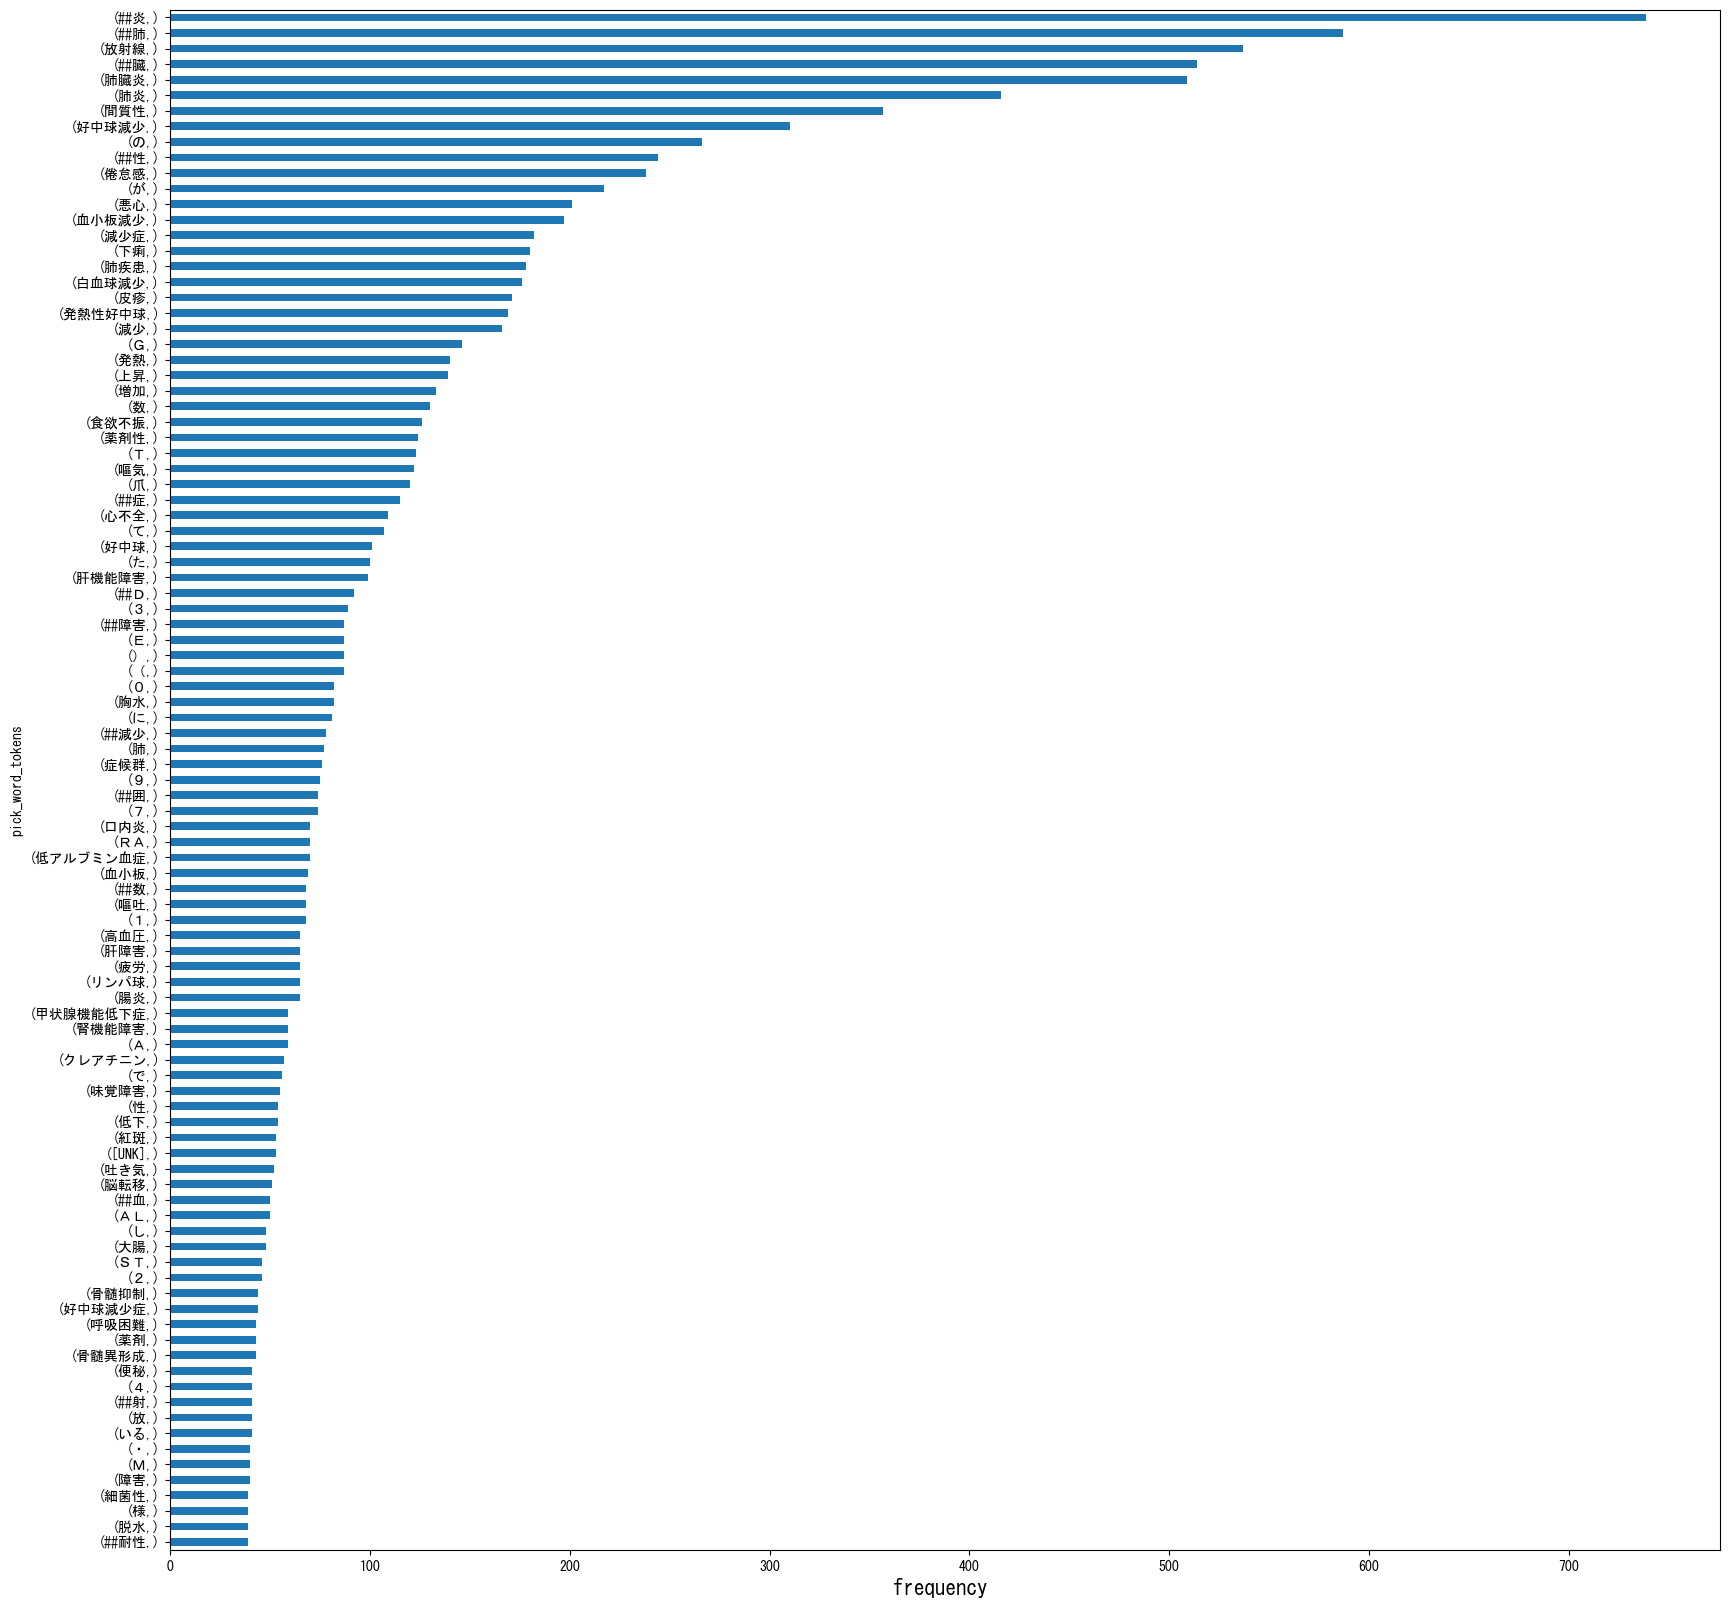

In [41]:
plt.figure(figsize=(20, 20))
pick_word_tokens.value_counts()[1:100].plot.barh().invert_yaxis()
plt.xlabel('frequency ',size = 15)

Text(0.5, 0, 'frequency ')

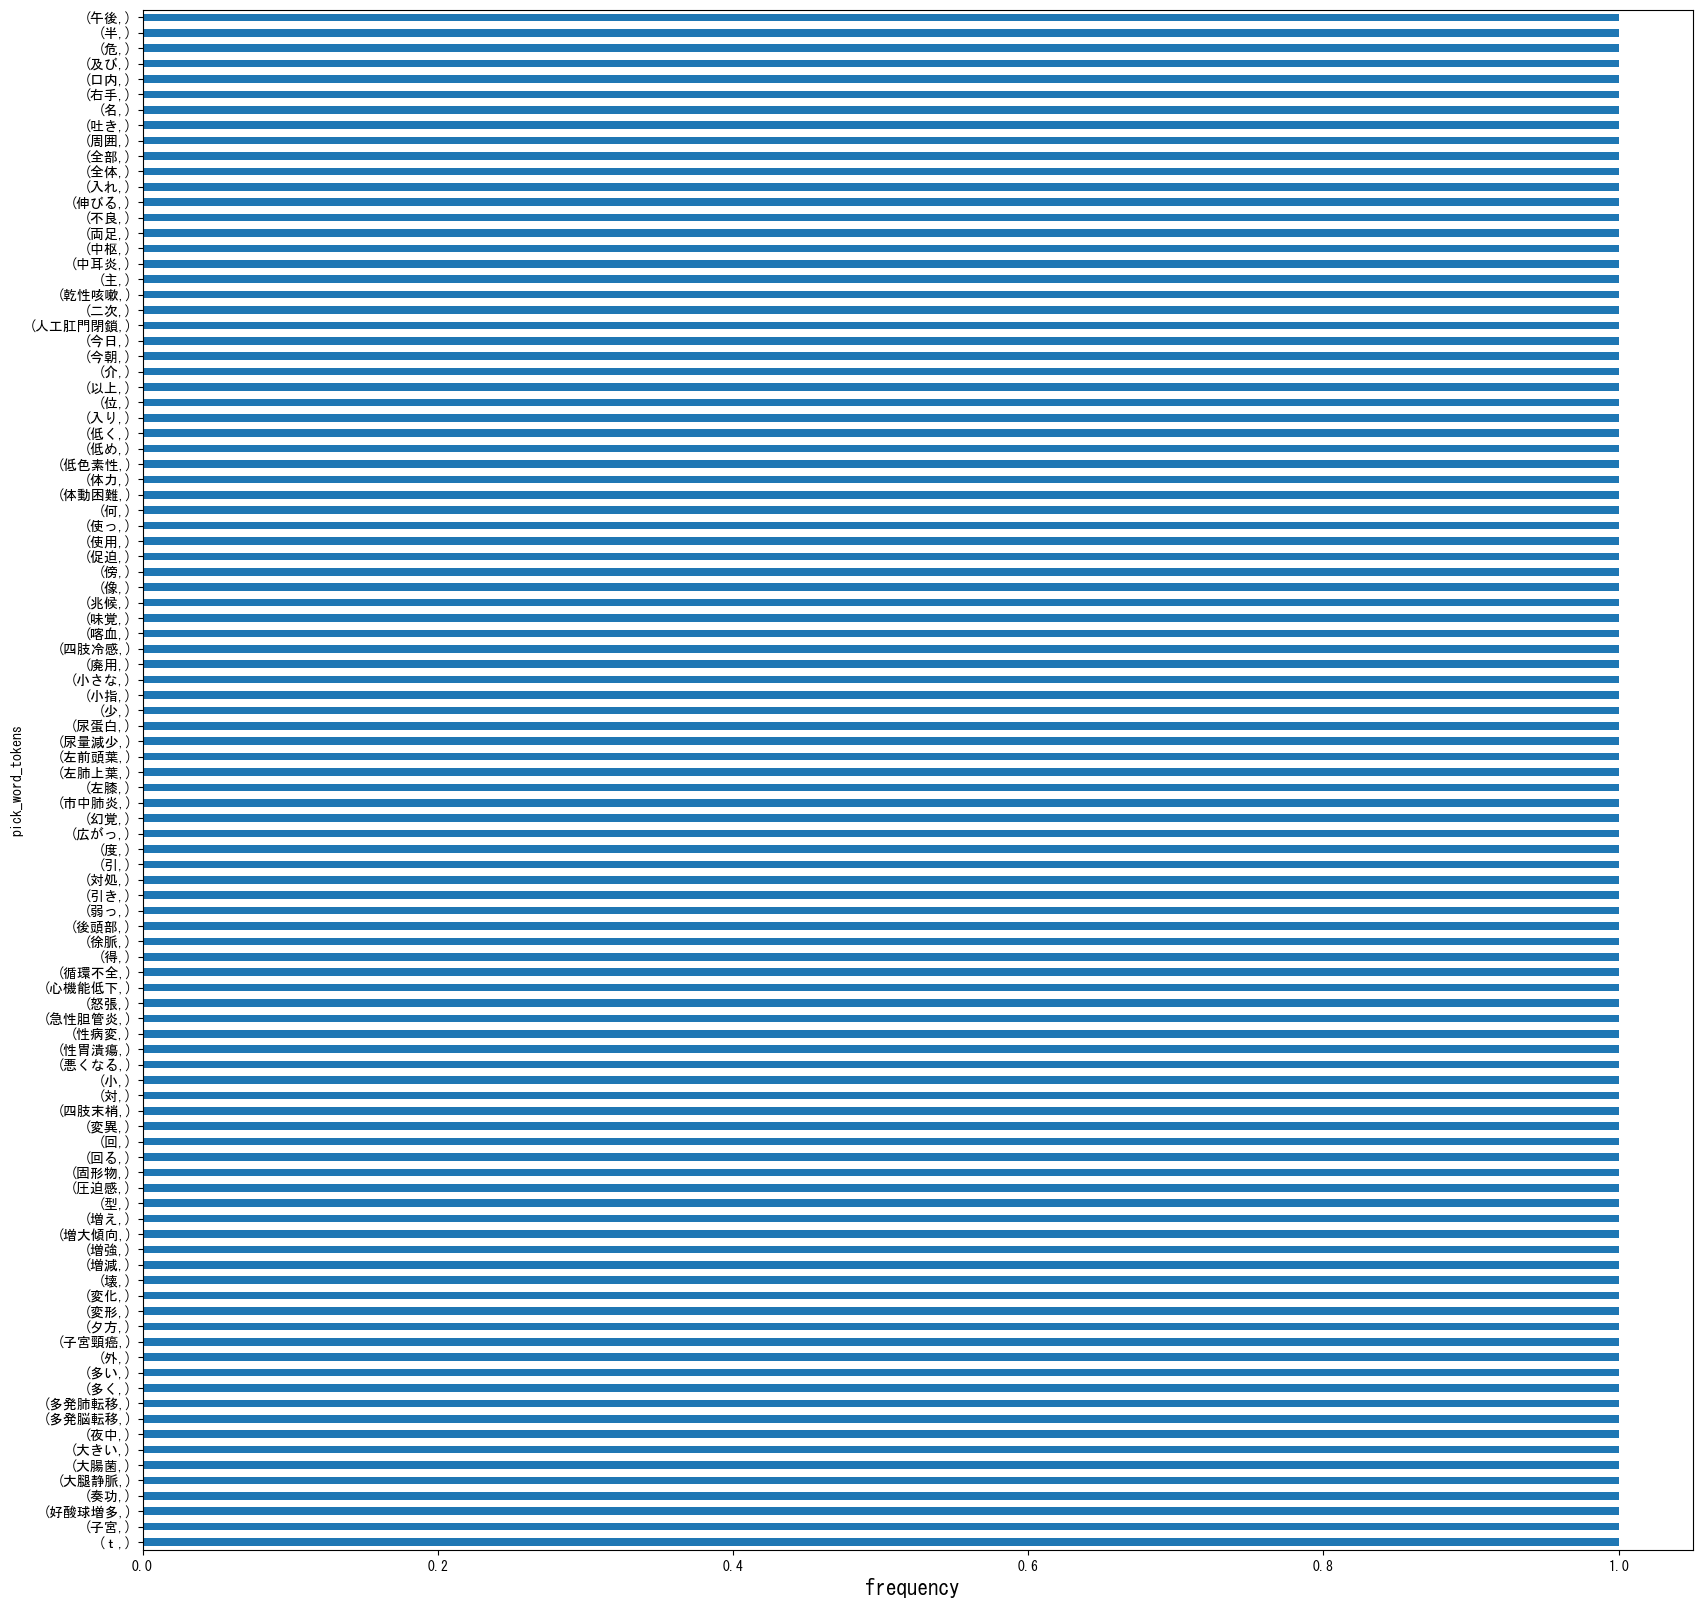

In [42]:
plt.figure(figsize=(20, 20))
pick_word_tokens.value_counts()[-100:].plot.barh().invert_yaxis()
plt.xlabel('frequency ',size = 15)